This notbook is used to demonstrate building classification models using tree-based classifiers. The dataset used for this exercise is borrowed from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

### Import packages

In [1]:
import pandas as pd

### Set-up

In [4]:
# input file location and name
infile = 'https://raw.githubusercontent.com/vishal-git/dapt-631/main/data/credit_default_model_data.csv'

# target variable (column name)
target = 'default payment next month'

### Read data

In [5]:
df = pd.read_csv(infile)
df.shape

(30000, 57)

In [6]:
df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_-2_flag,pay_bucket_-1_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,group,default payment next month
0,40000,28,10371,11895,11228,2475,5341,6255,2567,0,...,0,1,11883,47565,0.249827,0,0.198187,0.297375,M,1
1,320000,35,12233,16490,20011,17918,18627,19167,7000,4100,...,0,0,15100,104446,0.144572,0,0.054399,0.062534,M,0
2,260000,35,188,188,188,188,194,188,188,188,...,0,1,1167,1134,1.029101,0,0.000727,0.000746,M,0
3,360000,36,308711,305594,306176,304645,315118,315782,11000,13000,...,0,0,71322,1856026,0.038427,0,0.859271,0.877172,M,0
4,500000,25,-46,9412,1260,0,1121,6566,9458,1260,...,0,1,20839,18313,1.137935,0,0.006104,0.018824,M,0


In [8]:
df.group.value_counts()

M    15000
T     7500
V     7500
Name: group, dtype: int64

In [9]:
y = df[target]
X = df.drop(target, axis=1)

X_train = X[X['group'] == 'M'].drop('group', axis=1)
X_test = X[X['group'] == 'T'].drop('group', axis=1)
X_valid = X[X['group'] == 'V'].drop('group', axis=1)

y_train = y[X['group'] == 'M']
y_test = y[X['group'] == 'T']
y_valid = y[X['group'] == 'V']

len(X_train), len(X_test), len(X_valid)

(15000, 7500, 7500)

In [10]:
del df

### Initial Models

In [11]:
# import sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# define classifiers
logit = LogisticRegression(max_iter=1000, random_state=314)
tree = DecisionTreeClassifier(max_depth=4, random_state=314)
forest = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=314)
gboost = GradientBoostingClassifier(max_depth=4, random_state=314)

Fit the models.

In [12]:
models = [logit, tree, forest, gboost]

for model in models:
    model.fit(X_train, y_train)

Save the predicted probabilities (scores) for the train and test paritions for each model.

In [13]:
logit_scores_train = logit.predict_proba(X_train)[:, 1]
logit_scores_test = logit.predict_proba(X_test)[:, 1]

tree_scores_train = tree.predict_proba(X_train)[:, 1]
tree_scores_test = tree.predict_proba(X_test)[:, 1]

forest_scores_train = forest.predict_proba(X_train)[:, 1]
forest_scores_test = forest.predict_proba(X_test)[:, 1]

gboost_scores_train = gboost.predict_proba(X_train)[:, 1]
gboost_scores_test = gboost.predict_proba(X_test)[:, 1]

### ROC Curves

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculate the false positive and true positive rates
logit_fpr_train, logit_tpr_train, _ = roc_curve(y_train, logit_scores_train)
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)

tree_fpr_train, tree_tpr_train, _ = roc_curve(y_train, tree_scores_train)
tree_fpr_test, tree_tpr_test, _ = roc_curve(y_test, tree_scores_test)

forest_fpr_train, forest_tpr_train, _ = roc_curve(y_train, forest_scores_train)
forest_fpr_test, forest_tpr_test, _ = roc_curve(y_test, forest_scores_test)

gboost_fpr_train, gboost_tpr_train, _ = roc_curve(y_train, gboost_scores_train)
gboost_fpr_test, gboost_tpr_test, _ = roc_curve(y_test, gboost_scores_test)

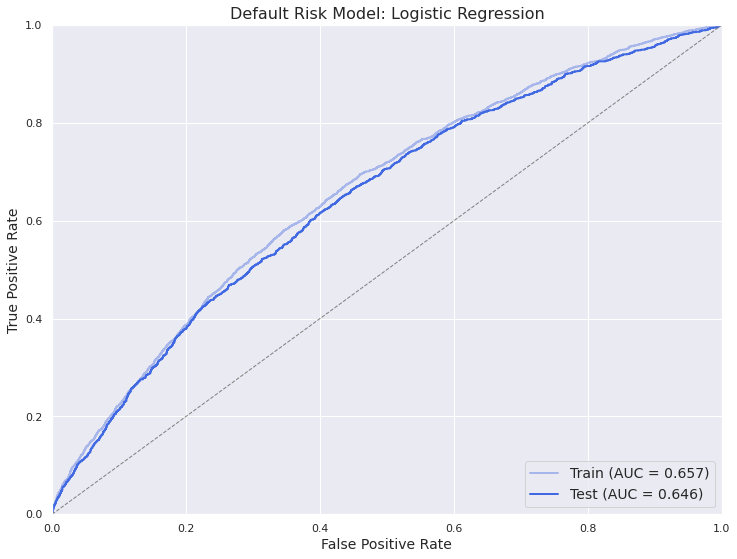

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.figure(figsize=(12, 9))

# train
plt.plot(logit_fpr_train, logit_tpr_train, color='royalblue', lw=2, alpha=0.4,
         label=f'Train (AUC = {roc_auc_score(y_train, logit_scores_train):0.3f})')

# test
plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, 
         label=f'Test (AUC = {roc_auc_score(y_test, logit_scores_test):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Default Risk Model: Logistic Regression', fontsize=16)
plt.legend(loc="lower right", fontsize=14);

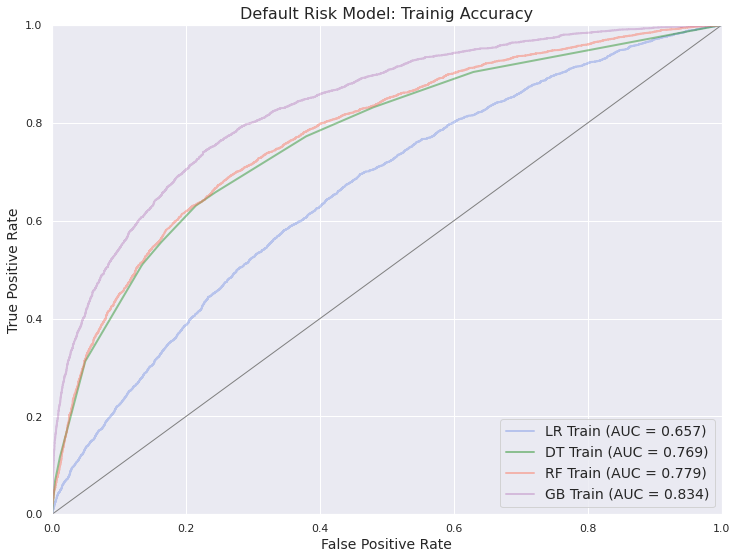

In [16]:
plt.figure(figsize=(12, 9))

plt.plot(logit_fpr_train, logit_tpr_train, color='royalblue', lw=2, alpha=0.3,
         label=f'LR Train (AUC = {roc_auc_score(y_train, logit_scores_train):0.3f})')

plt.plot(tree_fpr_train, tree_tpr_train, color='green', lw=2, alpha=0.4,
         label=f'DT Train (AUC = {roc_auc_score(y_train, tree_scores_train):0.3f})')

plt.plot(forest_fpr_train, forest_tpr_train, color='tomato', lw=2, alpha=0.4,
         label=f'RF Train (AUC = {roc_auc_score(y_train, forest_scores_train):0.3f})')

plt.plot(gboost_fpr_train, gboost_tpr_train, color='purple', lw=2, alpha=0.2,
         label=f'GB Train (AUC = {roc_auc_score(y_train, gboost_scores_train):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Trainig Accuracy', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

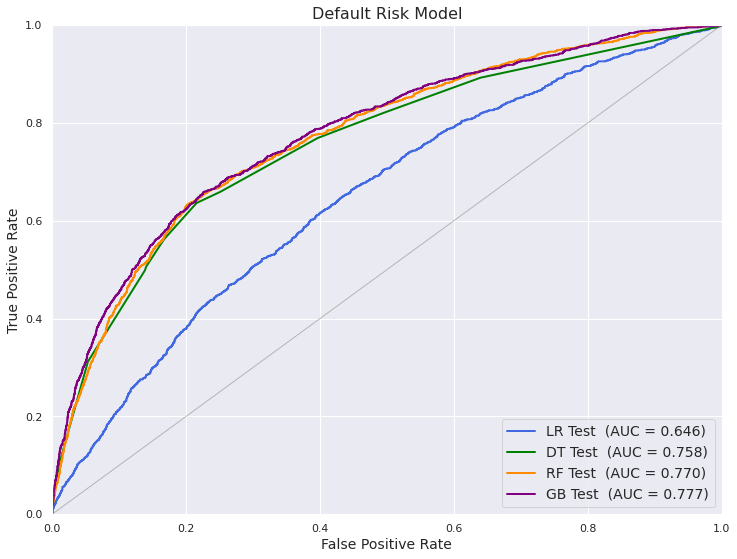

In [17]:
plt.figure(figsize=(12, 9))

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2,
         label=f'LR Test  (AUC = {roc_auc_score(y_test, logit_scores_test):0.3f})')

plt.plot(tree_fpr_test, tree_tpr_test, color='green', lw=2,
         label=f'DT Test  (AUC = {roc_auc_score(y_test, tree_scores_test):0.3f})')

plt.plot(forest_fpr_test, forest_tpr_test, color='darkorange', lw=2,
         label=f'RF Test  (AUC = {roc_auc_score(y_test, forest_scores_test):0.3f})')

plt.plot(gboost_fpr_test, gboost_tpr_test, color='purple', lw=2,
         label=f'GB Test  (AUC = {roc_auc_score(y_test, gboost_scores_test):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, alpha=.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Default Risk Model', fontsize=16)
plt.legend(loc="lower right", fontsize=14);

We haven't standardized the input features. Let's see what happens when we do that.

### Logistic Regression *with Standardization*

In [18]:
from sklearn.preprocessing import StandardScaler

# define a scaler
X_scaler = StandardScaler()

# fit the model after stadardizing all variables
logit.fit(X_scaler.fit_transform(X_train.astype(float)), y_train)

# get model scores
logit_scores_train = logit.predict_proba(X_scaler.transform(X_train.astype(float)))[:, 1]
logit_scores_test = logit.predict_proba(X_scaler.transform(X_test.astype(float)))[:, 1]

# calculate False Positive Rates and True Positive Rates
logit_fpr_train, logit_tpr_train, _ = roc_curve(y_train, logit_scores_train)
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)

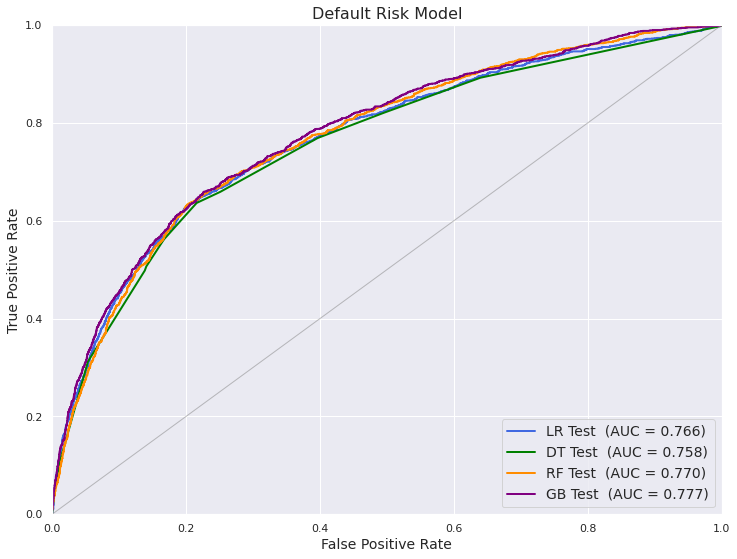

In [19]:
plt.figure(figsize=(12, 9))

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2,
         label=f'LR Test  (AUC = {roc_auc_score(y_test, logit_scores_test):0.3f})')

plt.plot(tree_fpr_test, tree_tpr_test, color='green', lw=2,
         label=f'DT Test  (AUC = {roc_auc_score(y_test, tree_scores_test):0.3f})')

plt.plot(forest_fpr_test, forest_tpr_test, color='darkorange', lw=2,
         label=f'RF Test  (AUC = {roc_auc_score(y_test, forest_scores_test):0.3f})')

plt.plot(gboost_fpr_test, gboost_tpr_test, color='purple', lw=2,
         label=f'GB Test  (AUC = {roc_auc_score(y_test, gboost_scores_test):0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, alpha=.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Default Risk Model', fontsize=16)
plt.legend(loc="lower right", fontsize=14);

In the next session, we will work on optimizing the model hyper-parameters to try to improve their performance. 